In [1]:
from astropy.io import ascii
from astropy.io import fits
import matplotlib.pyplot as plt
from photutils import Background2D
from astropy.table import Column
from photutils  import detect_sources
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import source_properties
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_100gaussians_image
from photutils.detection import find_peaks
import numpy as np
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from astropy.io import fits
from random import random
import networkx as nx
import tqdm
import networkx.algorithms.community as nx_comm
import pandas as pd


### Define functions to generate networks with images:

In [2]:
def pk(r,r0):
    return np.exp(-r/r0)

def sep(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

def network_generator_cerebellum(path,r0=24,show=False):
    im=fits.open(path)[0]
    if show: plt.imshow(im.data,cmap='Greys_r',origin='lower')
    mean, median, std = sigma_clipped_stats(im.data, sigma=3.0)
    threshold = median + (3* std)
    tbl = find_peaks(im.data, threshold, box_size=10)
    tbl['peak_value'].info.format = '%.8g'
    t=(max(np.log(tbl['peak_value']))-min(np.log(tbl['peak_value'])))/3
    print(min(np.log(tbl['peak_value']))+t)
    tbl['peak_value']=np.log(tbl['peak_value'])
#     #print(t)
#     plt.plot(tbl['peak_value'])
#     plt.show()
    print(len(tbl))
    N=len(tbl)
    #print((min(tbl['peak_value'][0])+t))
    #A=np.zeros([N,N])
    G = nx.Graph()
    att=None
    for i in tqdm.tqdm(range(N)):
        if tbl['peak_value'][i]<=(min(tbl['peak_value'])+t):
            att='low'
        if tbl['peak_value'][i]>=min(tbl['peak_value'])+t and tbl['peak_value'][i]<=min(tbl['peak_value'])+2*t:
            att='medium'
        if tbl['peak_value'][i]>=min(tbl['peak_value'])+2*t:
            att='high'
        G.add_node(i, attr_dict=att)
    for i in tqdm.tqdm(range(N)):
        for j in range(N):
            if i>j:
                r=sep(tbl['x_peak'][i],tbl['y_peak'][i],tbl['x_peak'][j],tbl['y_peak'][j])
                if pk(r,r0)>random():
                    G.add_edge(i,j)
                    
    return G


def network_generator_galaxy(path,r0=28.8,show=False):
    im=fits.open(path)[0]
    if show: plt.imshow(im.data[0],cmap='Greys_r',origin='lower')
    mean, median, std = sigma_clipped_stats(im.data[0], sigma=3.0)
    threshold = 2.5*median + (5*std)
    tbl = find_peaks(im.data[0], threshold, box_size=10)
    tbl['peak_value'].info.format = '%.8g'
    tbl['peak_value']=np.log(tbl['peak_value'])
    t=(max(tbl['peak_value'])-min(tbl['peak_value']))/3
    print(len(tbl))
    N=len(tbl)
    #A=np.zeros([N,N])
    G = nx.Graph()
    att=None
    for i in tqdm.tqdm(range(N)):
        if tbl['peak_value'][i]<=(min(tbl['peak_value'])+t):
            att='low'
        if tbl['peak_value'][i]>=min(tbl['peak_value'])+t and tbl['peak_value'][i]<=min(tbl['peak_value'])+2*t:
            att='medium'
        if tbl['peak_value'][i]>=min(tbl['peak_value'])+2*t:
            att='high'
        G.add_node(i, attr_dict=att)
    for i in tqdm.tqdm(range(N)):
        for j in range(N):
            if i>j:
                r=sep(tbl['x_peak'][i],tbl['y_peak'][i],tbl['x_peak'][j],tbl['y_peak'][j])
                if pk(r,r0)>random():
                    G.add_edge(i,j)
    return G

def network_generator_cortex(path,r0=24,show=False):
    im=fits.open(path)[0]
    if show: plt.imshow(im.data,cmap='Greys_r',origin='lower')
    mean, median, std = sigma_clipped_stats(im.data, sigma=3.0)
    threshold = median + (5* std)
    tbl = find_peaks(im.data, threshold, box_size=10)
    tbl['peak_value'].info.format = '%.8g'
    tbl['peak_value']=np.log(tbl['peak_value'])
    t=(max(tbl['peak_value'])-min(tbl['peak_value']))/3
    print(len(tbl))
    N=len(tbl)
    #A=np.zeros([N,N])
    G = nx.Graph()
    att=None
    for i in tqdm.tqdm(range(N)):
        if tbl['peak_value'][i]<=(min(tbl['peak_value'])+t):
            att='low'
        if tbl['peak_value'][i]>=min(tbl['peak_value'])+t and tbl['peak_value'][i]<=min(tbl['peak_value'])+2*t:
            att='medium'
        if tbl['peak_value'][i]>=min(tbl['peak_value'])+2*t:
            att='high'
        G.add_node(i, attr_dict=att)
    for i in tqdm.tqdm(range(N)):
        for j in range(N):
            if i>j:
                r=sep(tbl['x_peak'][i],tbl['y_peak'][i],tbl['x_peak'][j],tbl['y_peak'][j])
                if pk(r,r0)>random():
                    G.add_edge(i,j)
                    
    return G


### Define clasic analysis function which its out put is :
* Average Shortest Path
* Clustering Coefficient
* Modularity
* Diameter
 And a function for entropy

In [3]:
def classical_analysis(G_list):
    avg_shortest_path=[]
    avg_clustering=[]
    modularity = []
    diameter = []
    sigma = []
    for i in tqdm.tqdm(range(len(G_list))):
        avg_shortest_path.append(nx.average_shortest_path_length(G_list[i]))#G0))
        avg_clustering.append(nx.average_clustering(G_list[i]))
        partition = nx.algorithms.community.greedy_modularity_communities(G_list[i])
        modularity.append(nx_comm.modularity(G_list[i],partition))
        diameter.append(nx.diameter(G_list[i]))
        #sigma.append(nx.omega(G_list[i]))
        
    return  [avg_shortest_path, avg_clustering, modularity, diameter, sigma]

def entropy(G_list):
    S = []
    for i in tqdm.tqdm(range(len(G_list))):
        G = G_list[i].copy()
        N = len(G.nodes())
        #print(N)
        Ls = np.array(sorted(nx.linalg.spectrum.laplacian_spectrum(G_list[i])))
        #taus = np.geomspace(10**-1/Ls[-1],100/Ls[1])
        taus = np.geomspace(10**-2,10**6)
        s = []
        for tau in taus:
            p = np.exp(-tau*Ls)
            z = np.sum(p)
            p = p/z
            p = np.delete(p,np.where(p<10**-8))
            s.append(-np.sum(p*np.log(p))/np.log(N))
        S.append(s)
    S = np.array(S)
    return np.mean(S,axis=0), np.var(S,axis=0),taus

### Obtain all the parameters which we need for comparison of these networks:

3992


100%|██████████| 3992/3992 [01:40<00:00, 39.54it/s] 


0  G_Galaxy generated


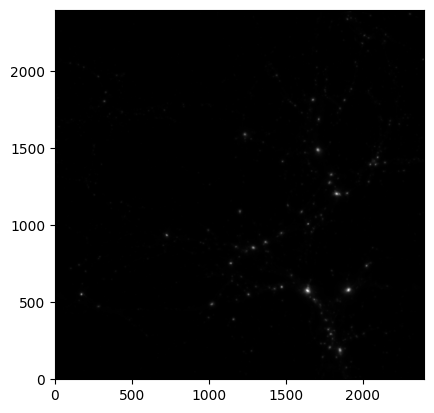

In [15]:
G_Galaxy = []
for i in range(1):
    G = network_generator_galaxy("map_gasDMD_188_1024_X_C.fits",show=True)
    G_Galaxy.append(G)
    print(i,' G_Galaxy generated')
    

In [11]:
e=len(list(G_Galaxy[0].edges()))
n=3992

In [15]:
#avrage conectivity
(2*e)/(n*(n-1))

0.001172979886106465

In [16]:
# avarage degree
(2*e)/n

4.681362725450902

In [29]:
G_CEREBELLUM[0]

IndexError: list index out of range

In [4]:
G_CEREBELLUM = []
for i in range(1):
    G = network_generator_cerebellum("CEREBELLUM40.fits",show=False)
    G_CEREBELLUM.append(G)
    print(i,' G_CEREBELLUM generated')

2.5839998722076416
2492


100%|██████████| 2492/2492 [00:40<00:00, 61.34it/s] 

0  G_CEREBELLUM generated


In [64]:
g = G_Galaxy[0]
nx.get_node_attributes(g,'attr_dict')

{0: 'low',
 1: 'low',
 2: 'low',
 3: 'low',
 4: 'low',
 5: 'low',
 6: 'low',
 7: 'low',
 8: 'low',
 9: 'medium',
 10: 'low',
 11: 'low',
 12: 'low',
 13: 'low',
 14: 'low',
 15: 'low',
 16: 'low',
 17: 'low',
 18: 'medium',
 19: 'low',
 20: 'medium',
 21: 'low',
 22: 'low',
 23: 'medium',
 24: 'low',
 25: 'low',
 26: 'low',
 27: 'low',
 28: 'medium',
 29: 'low',
 30: 'low',
 31: 'low',
 32: 'low',
 33: 'low',
 34: 'low',
 35: 'low',
 36: 'low',
 37: 'low',
 38: 'low',
 39: 'medium',
 40: 'low',
 41: 'low',
 42: 'low',
 43: 'low',
 44: 'low',
 45: 'low',
 46: 'low',
 47: 'low',
 48: 'low',
 49: 'low',
 50: 'low',
 51: 'low',
 52: 'low',
 53: 'medium',
 54: 'low',
 55: 'low',
 56: 'low',
 57: 'low',
 58: 'low',
 59: 'medium',
 60: 'medium',
 61: 'low',
 62: 'low',
 63: 'low',
 64: 'low',
 65: 'low',
 66: 'low',
 67: 'low',
 68: 'medium',
 69: 'medium',
 70: 'low',
 71: 'low',
 72: 'low',
 73: 'low',
 74: 'low',
 75: 'low',
 76: 'low',
 77: 'low',
 78: 'high',
 79: 'low',
 80: 'low',
 81:

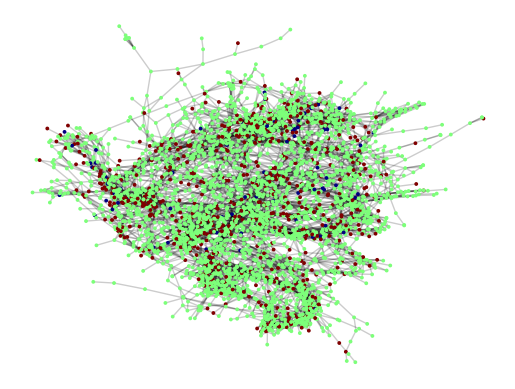

Homophily=0.3846743295019157
Assortavity=0.29801179245655474


In [114]:
from itertools import count

g = G_Galaxy[0]
groups = set(nx.get_node_attributes(g,'attr_dict').values())
mapping = dict(zip(sorted(groups),count()))
nodes = g.nodes()
colors = [mapping[g.nodes[n]['attr_dict']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=3, cmap=plt.cm.jet)
#plt.colorbar(nc)
plt.axis('off')
plt.show()

char = nx.get_node_attributes(G,'attr_dict')
def homophily(G, chars):

    num_same_ties = 0
    num_ties = 0
    for n1, n2 in G.edges():
        if n1 in chars and n2 in chars:
            if G.has_edge(n1, n2):
                num_ties+=1
                if chars[n1] == chars[n2]:
                    num_same_ties+=1
    return (num_same_ties / num_ties)

print('Homophily={}'.format(homophily(g, char)))
print('Assortavity={}'.format(nx.degree_assortativity_coefficient(g)))

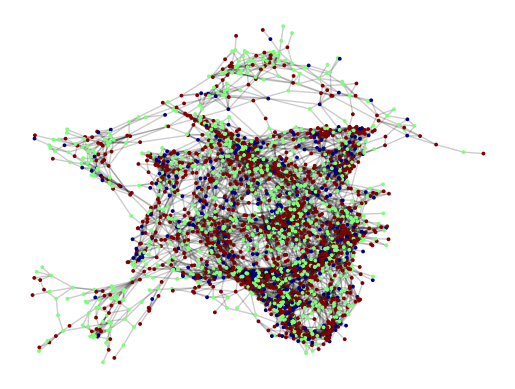

Homophily=0.40275250227479525
Assortavity=0.3999804298151216


In [99]:
from itertools import count

g = G_CEREBELLUM[0]
groups = set(nx.get_node_attributes(g,'attr_dict').values())
mapping = dict(zip(sorted(groups),count()))
nodes = g.nodes()
colors = [mapping[g.nodes[n]['attr_dict']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=3, cmap=plt.cm.jet)
#plt.colorbar(nc)
plt.axis('off')
plt.show()

char = nx.get_node_attributes(G,'attr_dict')
def homophily(G, chars):

    num_same_ties = 0
    num_ties = 0
    for n1, n2 in G.edges():
        if n1 in chars and n2 in chars:
            if G.has_edge(n1, n2):
                num_ties+=1
                if chars[n1] == chars[n2]:
                    num_same_ties+=1
    return (num_same_ties / num_ties)

print('Homophily={}'.format(homophily(g, char)))
print('Assortavity={}'.format(nx.degree_assortativity_coefficient(g)))

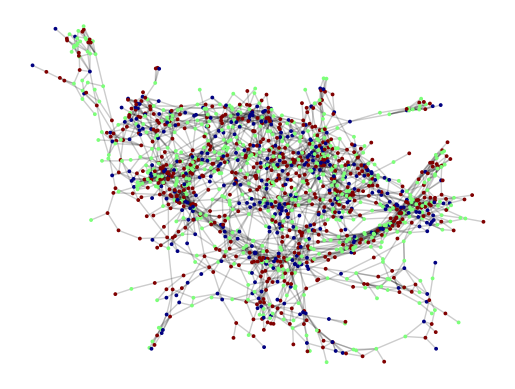

Homophily=0.38545454545454544
Assortavity=0.24235405375985997


In [100]:
from itertools import count

g = G_cortex[0]
groups = set(nx.get_node_attributes(g,'attr_dict').values())
mapping = dict(zip(sorted(groups),count()))
nodes = g.nodes()
colors = [mapping[g.nodes[n]['attr_dict']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=3, cmap=plt.cm.jet)
#plt.colorbar(nc)
plt.axis('off')
plt.show()

char = nx.get_node_attributes(G,'attr_dict')
def homophily(G, chars):

    num_same_ties = 0
    num_ties = 0
    for n1, n2 in G.edges():
        if n1 in chars and n2 in chars:
            if G.has_edge(n1, n2):
                num_ties+=1
                if chars[n1] == chars[n2]:
                    num_same_ties+=1
    return (num_same_ties / num_ties)

print('Homophily={}'.format(homophily(g, char)))
print('Assortavity={}'.format(nx.degree_assortativity_coefficient(g)))

In [18]:
e=len(list(G_CEREBELLUM[0].edges()))
n=2492
# avarage degree
(2*e)/n

7.145264847512038

1560


100%|██████████| 1560/1560 [00:15<00:00, 101.91it/s]


0 G_cortex generated


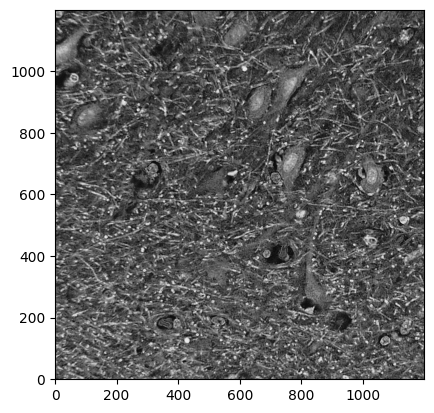

In [16]:
G_cortex = []
for i in range(1):
    G = network_generator_cortex("CORTEX40.fits",show=True)
    G_cortex.append(G)
    print(i,'G_cortex generated')

In [72]:
G = G_cortex[0]
char = nx.get_node_attributes(G,'attr_dict')
def homophily(G, chars):

    num_same_ties = 0
    num_ties = 0
    for n1, n2 in G.edges():
        if n1 in chars and n2 in chars:
            if G.has_edge(n1, n2):
                num_ties+=1
                if chars[n1] == chars[n2]:
                    num_same_ties+=1
    return (num_same_ties / num_ties)

print(homophily(G, char))

0.36654697785757034


In [21]:
e=len(list(G_CEREBELLUM[0].edges()))
n=1560
# avarage degree
(2*e)/n

11.414102564102564

3992


100%|██████████| 3992/3992 [02:56<00:00, 22.63it/s]


0  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:13<00:00, 29.91it/s]


1  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:58<00:00, 33.70it/s] 


2  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:00<00:00, 33.21it/s]


3  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:12<00:00, 30.17it/s]


4  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:48<00:00, 36.71it/s] 


5  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:10<00:00, 30.65it/s] 


6  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:31<00:00, 43.81it/s]


7  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:18<00:00, 28.93it/s] 


8  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:13<00:00, 29.99it/s] 


9  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:54<00:00, 34.87it/s]


10  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:02<00:00, 32.57it/s] 


11  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:48<00:00, 36.74it/s]


12  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:10<00:00, 30.51it/s]


13  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:02<00:00, 32.61it/s]


14  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:54<00:00, 34.77it/s] 


15  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:36<00:00, 41.52it/s] 


16  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:51<00:00, 35.71it/s] 


17  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:00<00:00, 33.00it/s]


18  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:59<00:00, 33.49it/s]


19  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:08<00:00, 31.09it/s] 


20  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:35<00:00, 41.75it/s] 


21  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:31<00:00, 43.55it/s] 


22  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:07<00:00, 31.40it/s] 


23  G_Galaxy generated
3992


100%|██████████| 3992/3992 [04:08<00:00, 16.04it/s]


24  G_Galaxy generated
3992


100%|██████████| 3992/3992 [03:52<00:00, 17.20it/s]


25  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:36<00:00, 41.28it/s] 


26  G_Galaxy generated
3992


100%|██████████| 3992/3992 [01:19<00:00, 49.98it/s] 


27  G_Galaxy generated
3992


100%|██████████| 3992/3992 [02:41<00:00, 24.73it/s] 


28  G_Galaxy generated
3992


100%|██████████| 3992/3992 [03:05<00:00, 21.56it/s] 


29  G_Galaxy generated


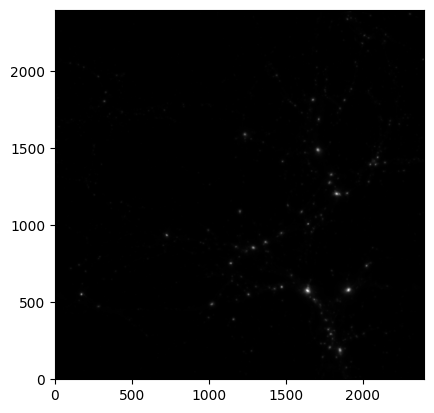

In [28]:
G_Galaxy = []
for i in range(30):
    G = network_generator_galaxy("map_gasDMD_188_1024_X_C.fits",show=True)
    G_Galaxy.append(G)
    print(i,' G_Galaxy generated')

2492


100%|██████████| 2492/2492 [00:26<00:00, 93.42it/s] 


0  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:28<00:00, 87.42it/s] 


1  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:28<00:00, 87.60it/s] 


2  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:28<00:00, 86.12it/s] 


3  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:26<00:00, 93.85it/s] 


4  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:27<00:00, 92.15it/s] 


5  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:28<00:00, 86.16it/s] 


6  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:26<00:00, 92.31it/s] 


7  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:28<00:00, 88.60it/s] 


8  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:29<00:00, 85.66it/s] 


9  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:28<00:00, 88.67it/s] 


10  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:31<00:00, 80.31it/s] 


11  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:27<00:00, 90.30it/s] 


12  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:27<00:00, 91.42it/s] 


13  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:32<00:00, 76.95it/s] 


14  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:29<00:00, 84.30it/s] 


15  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:28<00:00, 86.10it/s] 


16  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:29<00:00, 83.63it/s] 


17  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:30<00:00, 80.41it/s] 


18  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:29<00:00, 85.14it/s] 


19  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:27<00:00, 90.18it/s] 


20  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:29<00:00, 85.00it/s] 


21  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:27<00:00, 90.49it/s] 


22  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:26<00:00, 92.77it/s] 


23  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:30<00:00, 80.74it/s] 


24  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:30<00:00, 80.47it/s] 


25  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:30<00:00, 81.63it/s] 


26  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:28<00:00, 87.13it/s] 


27  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:32<00:00, 77.38it/s] 


28  G_CEREBELLUM generated
2492


100%|██████████| 2492/2492 [00:30<00:00, 80.63it/s] 


29  G_CEREBELLUM generated


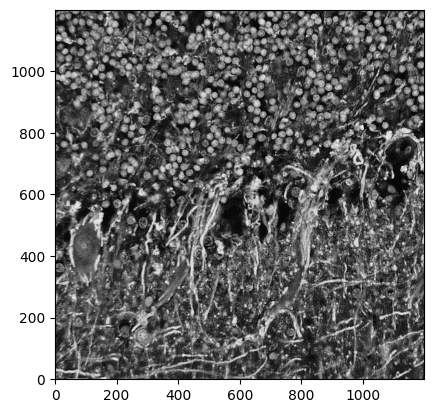

In [97]:
G_CEREBELLUM = []
for i in range(30):
    G = network_generator_cerebellum("CEREBELLUM40.fits",show=True)
    G_CEREBELLUM.append(G)
    print(i,' G_CEREBELLUM generated')

1560


100%|██████████| 1560/1560 [00:10<00:00, 151.68it/s]


0 G_cortex generated
1560


100%|██████████| 1560/1560 [00:11<00:00, 136.81it/s]


1 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 154.26it/s]


2 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 151.83it/s]


3 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 143.31it/s]


4 G_cortex generated
1560


100%|██████████| 1560/1560 [00:11<00:00, 131.02it/s]


5 G_cortex generated
1560


100%|██████████| 1560/1560 [00:11<00:00, 141.81it/s]


6 G_cortex generated
1560


100%|██████████| 1560/1560 [00:11<00:00, 140.49it/s]


7 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 147.12it/s]


8 G_cortex generated
1560


100%|██████████| 1560/1560 [00:09<00:00, 158.49it/s]


9 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 145.09it/s]


10 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 145.61it/s]


11 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 143.73it/s]


12 G_cortex generated
1560


100%|██████████| 1560/1560 [00:11<00:00, 140.18it/s]


13 G_cortex generated
1560


100%|██████████| 1560/1560 [00:11<00:00, 139.23it/s]


14 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 147.46it/s]


15 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 143.85it/s]


16 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 145.75it/s]


17 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 143.30it/s]


18 G_cortex generated
1560


100%|██████████| 1560/1560 [00:11<00:00, 133.60it/s]


19 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 152.23it/s]


20 G_cortex generated
1560


100%|██████████| 1560/1560 [00:11<00:00, 141.20it/s]


21 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 145.04it/s]


22 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 148.05it/s]


23 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 145.79it/s]


24 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 144.68it/s]


25 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 144.36it/s]


26 G_cortex generated
1560


100%|██████████| 1560/1560 [00:10<00:00, 147.84it/s]


27 G_cortex generated
1560


100%|██████████| 1560/1560 [00:11<00:00, 140.37it/s]


28 G_cortex generated
1560


100%|██████████| 1560/1560 [00:11<00:00, 136.00it/s]


29 G_cortex generated


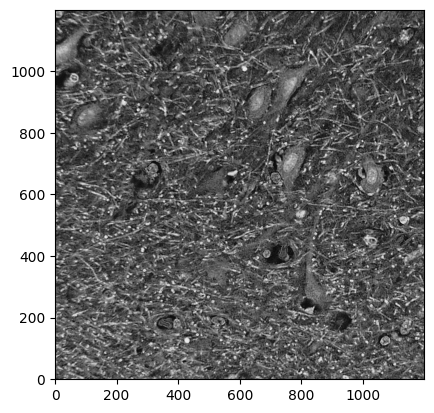

In [98]:
G_cortex = []
for i in range(30):
    G = network_generator_cortex("CORTEX40.fits",show=True)
    G_cortex.append(G)
    print(i,'G_cortex generated')

In [18]:
for i in tqdm.tqdm(range(len(G_cortex))):
        Gcc = sorted(nx.connected_components(G_cortex[i]), key=len, reverse=True)
        G_cortex[i] = G_cortex[i].subgraph(Gcc[0]).copy()

100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


In [19]:
for i in tqdm.tqdm(range(len(G_CEREBELLUM))):
        Gcc = sorted(nx.connected_components(G_CEREBELLUM[i]), key=len, reverse=True)
        G_CEREBELLUM[i] = G_CEREBELLUM[i].subgraph(Gcc[0]).copy()

100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


In [89]:
for i in tqdm.tqdm(range(len(G_Galaxy))):
        Gcc = sorted(nx.connected_components(G_Galaxy[i]), key=len, reverse=True)
        G_Galaxy[i] = G_Galaxy[i].subgraph(Gcc[0]).copy()

100%|██████████| 1/1 [00:00<00:00, 13.48it/s]


In [101]:
results_cortex = classical_analysis(G_cortex)    

100%|██████████| 30/30 [03:50<00:00,  7.68s/it]


In [102]:
results_cerebellum = classical_analysis(G_CEREBELLUM)    

100%|██████████| 30/30 [11:47<00:00, 23.58s/it]


In [68]:
results_galaxy = classical_analysis(G_Galaxy)    

100%|██████████| 30/30 [25:19<00:00, 50.66s/it]


### saving resualts:

In [158]:
df_cortex = pd.DataFrame({'avg_shortest_path': np.array(results_cortex[0],dtype=float),
                   'avg_clustering': np.array(results_cortex[1],dtype=float),
                   'modularity': np.array(results_cortex[2],dtype=float),
                  'diameter': np.array(results_cortex[3],dtype=float) })

df_cerebellum= pd.DataFrame({'avg_shortest_path': np.array(results_cerebellum[0],dtype=float),
                   'avg_clustering': np.array(results_cerebellum[1],dtype=float),
                   'modularity': np.array(results_cerebellum[2],dtype=float),
                  'diameter': np.array(results_cerebellum[3],dtype=float) })

df_galaxy = pd.DataFrame({'avg_shortest_path': np.array(results_galaxy[0],dtype=float),
                   'avg_clustering': np.array(results_galaxy[1],dtype=float),
                   'modularity': np.array(results_galaxy[2],dtype=float),
                  'diameter': np.array(results_galaxy[3],dtype=float) })

df_cortex.to_csv("results_cortex.csv")
df_cerebellum.to_csv("results_cerebellum.csv")
df_galaxy.to_csv("results_galaxy.csv")

Plot the histogram of parameters of all the ensembles in each network:

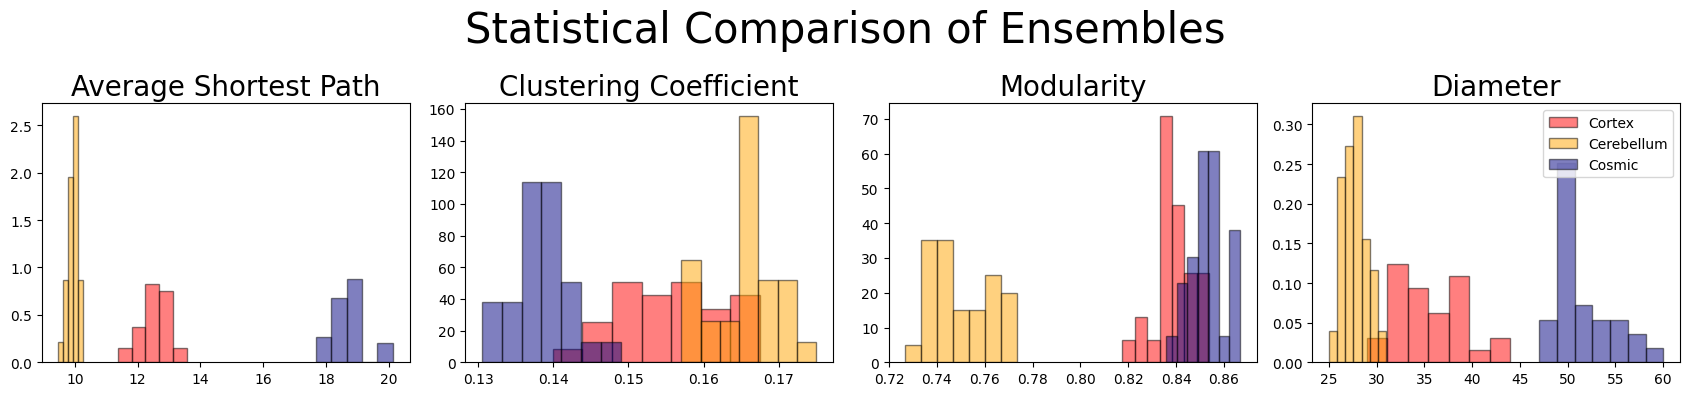

In [179]:
plt.figure(figsize=[17,4],layout='tight')
plt.suptitle('Statistical Comparison of Ensembles',fontsize=30)

colors = {'cortex': 'red', 'galaxy':'navy','cerebellum':'orange'}

plt.subplot(1,4,1)
plt.title('Average Shortest Path',fontsize=20)
plt.hist(results_cortex[0],bins=5, density = True, alpha=0.5,edgecolor='black',label='Cortex',color=colors['cortex'])
plt.hist(results_cerebellum[0],bins=5, density = True, alpha=0.5,edgecolor='black',label='Cerebellum',color=colors['cerebellum'])
plt.hist(results_galaxy[0],bins=5, density = True, alpha=0.5,edgecolor='black',label='Cosmic',color=colors['galaxy'])
#plt.hist(results_cerebelum[0])
#plt.hist(results_darkgalaxy[0])
#plt.hist(results_galaxy[0])

b=7

plt.subplot(1,4,2)
plt.title('Clustering Coefficient',fontsize=20)
plt.hist(results_cortex[1],bins=b, density = True, alpha=0.5,edgecolor='black',label='Cortex',color=colors['cortex'])
plt.hist(results_cerebellum[1],bins=b, density = True, alpha=0.5,edgecolor='black',label='Cerebellum',color=colors['cerebellum'])
plt.hist(results_galaxy[1],bins=b, density = True, alpha=0.5,edgecolor='black',label='Cosmic',color=colors['galaxy'])

plt.subplot(1,4,3)
plt.title('Modularity',fontsize=20)
plt.hist(results_cortex[2],bins=b, density = True, alpha=0.5,edgecolor='black',label='Cortex',color=colors['cortex'])
plt.hist(results_cerebellum[2],bins=b, density = True, alpha=0.5,edgecolor='black',label='cerebellum',color=colors['cerebellum'])
plt.hist(results_galaxy[2],bins=b, density = True, alpha=0.5,edgecolor='black',label='Cosmic',color=colors['galaxy'])

plt.subplot(1,4,4)
plt.title('Diameter',fontsize=20)
plt.hist(results_cortex[3],bins=b, density = True, alpha=0.5,edgecolor='black',label='Cortex',color=colors['cortex'])
plt.hist(results_cerebellum[3],bins=b, density = True, alpha=0.5,edgecolor='black',label='Cerebellum',color=colors['cerebellum'])
plt.hist(results_galaxy[3],bins=b, density = True, alpha=0.5,edgecolor='black',label='Cosmic',color=colors['galaxy'])

#plt.subplot(1,5,5)
#plt.title('Small-Worldness',fontsize=20)
#plt.hist(results_cortex[0],bins=10, alpha=0.5,edgecolor='black',label='Cortex',color=colors['cortex'])


plt.legend()

In [104]:
entropy_cortex, entropy_var_cortex, taus_cortex = entropy(G_cortex)

100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


In [105]:
entropy_cerebellum, entropy_var_cerebellum, taus_cerebellum= entropy(G_CEREBELLUM)

100%|██████████| 30/30 [01:12<00:00,  2.41s/it]


In [65]:
entropy_galaxy, entropy_var_galaxy, taus_galaxy = entropy(G_Galaxy)

100%|██████████| 30/30 [02:49<00:00,  5.66s/it]


### saving resualts:

In [194]:
df_cortex = pd.DataFrame({'entropy': np.array(entropy_cortex,dtype=float),
                   'entropy_var': np.array(entropy_var_cortex,dtype=float),
                   'taus': np.array(taus_cortex,dtype=float)})

df_cerebellum= pd.DataFrame({'entropy': np.array(entropy_cerebellum,dtype=float),
                   'entropy_var': np.array(entropy_var_cerebellum,dtype=float),
                   'taus': np.array(taus_cerebellum,dtype=float)})

df_galaxy = pd.DataFrame({'entropy': np.array(entropy_galaxy,dtype=float),
                   'entropy_var': np.array(entropy_var_galaxy,dtype=float),
                   'taus': np.array(taus_galaxy,dtype=float)})

df_cortex.to_csv("entropy_cortex.csv")
df_cerebellum.to_csv("entropy_cerebellum.csv")
df_galaxy.to_csv("entropy_galaxy.csv")

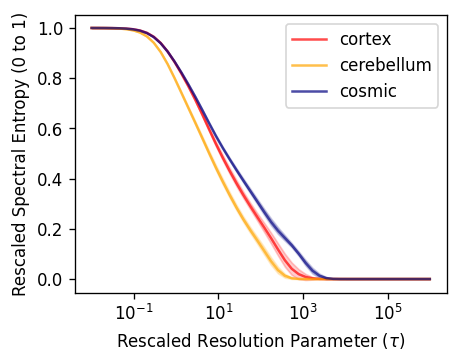

In [180]:
colors = {'cortex': 'red', 'galaxy':'navy','cerebellum':'orange'}
plt.figure(figsize=[4,3],dpi=120)
#cortex
y = entropy_cortex; error=np.sqrt(entropy_var_cortex) ; x = taus_cortex
plt.plot(x, y,label='cortex',alpha=0.7,color=colors['cortex'])
plt.fill_between(x, y-error, y+error,alpha=0.2,color=colors['cortex'])
#cerebellum
y = entropy_cerebellum; error=np.sqrt(entropy_var_cerebellum) ; x = taus_cerebellum
plt.plot(x, y,label='cerebellum',alpha=0.7,color=colors['cerebellum'])
plt.fill_between(x, y-error, y+error,alpha=0.2,color=colors['cerebellum'])
#cosmic
y = entropy_galaxy; error=np.sqrt(entropy_var_galaxy) ; x = taus_galaxy
plt.plot(x, y,label='cosmic',alpha=0.7,color=colors['galaxy'])
plt.fill_between(x, y-error, y+error,alpha=0.2,color=colors['galaxy'])
plt.ylabel('Rescaled Spectral Entropy (0 to 1)')
plt.xlabel('Rescaled Resolution Parameter ' + r'$(\tau)$')
plt.xscale('log')

plt.legend()

In [91]:
len(list(G_cortex[2].nodes()))

42

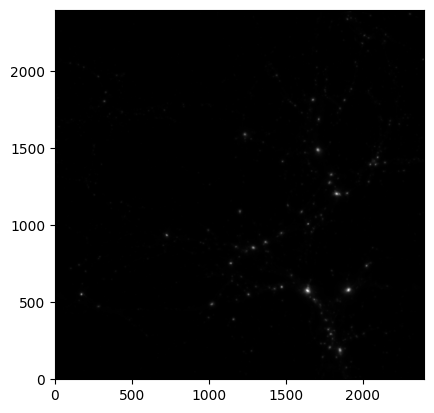

In [109]:
#load the image
im=fits.open('map_gasDMD_188_1024_X_C.fits')[0]

plt.imshow(im.data[0],cmap='Greys_r',origin='lower')

In [94]:
L=np.shape(im.data[0])[0]
L

1200

In [95]:
#cosmic
ps=1600/L
16/ps

12.0

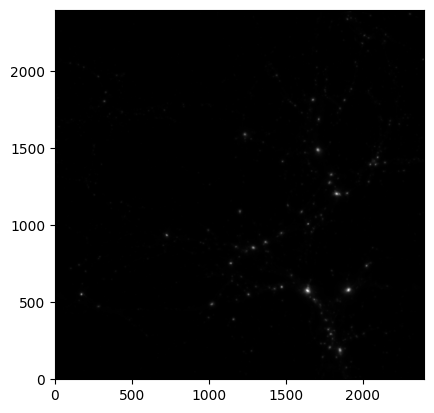

In [91]:
im=fits.open('map_gasDMD_188_1024_X_C.fits')[0]
plt.imshow(im.data[0],cmap='Greys_r',origin='lower')

## Finding peaks

In [110]:
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_100gaussians_image
from photutils.detection import find_peaks

mean, median, std = sigma_clipped_stats(im.data[0], sigma=3.0)
threshold = median + (5*std)
tbl = find_peaks(im.data[0], threshold, box_size=10)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(tbl[:10])  # print only the first 10 peaks
tbl.write('peaks_cos.csv' , format='ascii', overwrite=True)

x_peak y_peak   peak_value 
------ ------ -------------
  1226      0 1.4515084e-30
  1385      0 5.3942152e-31
  1735      0 2.6165346e-30
  1914      0 2.5209957e-30
   528      1 7.3425929e-31
  1039      2 1.3617828e-30
  1690      3 2.4141419e-30
  1774      3  1.062675e-30
  1795      3 4.6278409e-31
  1886      3 5.3892527e-30


In [19]:
len(tbl)

3992

### Source detection

C:\Users\rosha\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  


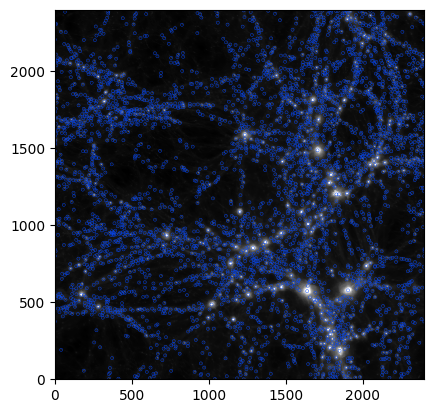

In [214]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=10.)
norm = simple_norm(im.data[0], 'sqrt', percent=99.9)
plt.imshow(im.data[0], cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
apertures.plot(color='#0547f9', lw=0.3)
plt.xlim(0, im.data[0].shape[1]-1)
plt.ylim(0, im.data[0].shape[0]-1)

plt.savefig('Peak finding_cos.pdf',dpi=1000,overwrite=True)

finding the network with probability pk(r,r0) by distance

In [24]:
from astropy.io import ascii
from astropy.io import fits
import numpy as np
from random import random
import networkx as nx
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

r0=28.8

def pk(r,r0):
    return np.exp(-r/r0)

def sep(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)
data=ascii.read('peaks_cos.csv')
N=len(data)
A=np.zeros([N,N])

for i in tqdm.tqdm(range(N)):
    for j in range(N):
        #r=sep(data['x_peak'][i],data['y_peak'][i],data['x_peak'][j],data['y_peak'][j])
        #A[i][j]=pk(r,r0)
        if i>j:
            r=sep(data['x_peak'][i],data['y_peak'][i],data['x_peak'][j],data['y_peak'][j])
            if pk(r,r0)>random():
                A[i][j]=1
                A[j][i]=1
            #else:
            #    A[i][j]=0
        #else:
        #    A[i][j]=0

100%|██████████| 3992/3992 [01:57<00:00, 33.94it/s] 


Text(0.5, 1.0, 'Probability Dist pk')

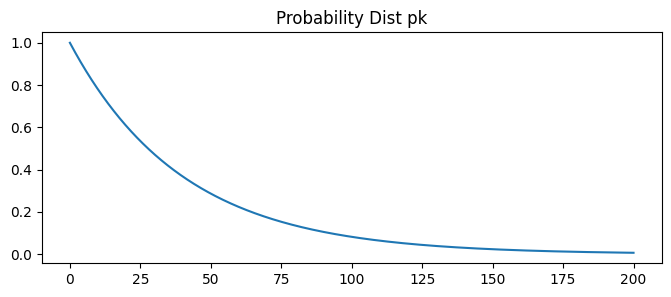

In [164]:
x=np.arange(0,200,0.001)
plt.figure(figsize=(8,3))
plt.plot(x,pk(x,40))
plt.title('Probability Dist pk')

* Plot the network on the image and save adjacency matrix

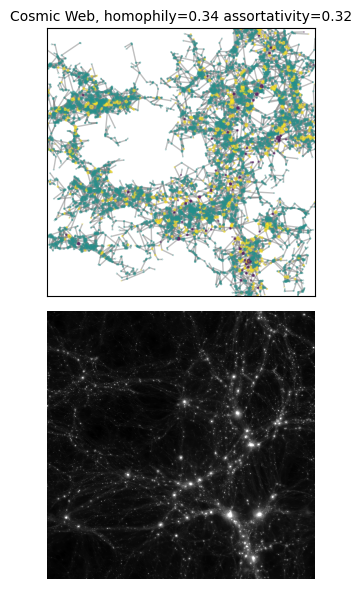

In [108]:
plt.figure(figsize=[3.5,6],layout='tight')
im=fits.open('map_gasDMD_188_1024_X_C.fits')[0]
data=ascii.read('peaks_cos.csv')
G=G_Galaxy[0]
groups = set(nx.get_node_attributes(G,'attr_dict').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['attr_dict']] for n in nodes]
pos={}
for i in range(len(data)):
    pos[i]=data['x_peak'][i],data['y_peak'][i]
    
#G = nx.from_numpy_array(A)

#im=fits.open('CEREBELLUM40.fits')[0]

plt.subplot(2,1,1)
plt.title('Cosmic Web, homophily='+str(0.34)+' assortativity='+ str(0.32),fontsize=10)
d = dict(G.degree)
norm = simple_norm(np.zeros(np.shape(im.data[0])), 'sqrt', percent=99.9)
plt.imshow(im.data[0], cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
nx.draw_networkx_nodes(G = G, pos = pos, node_color = colors, alpha = .5, node_size=[ (v**2) * .05 for v in d.values()])#,edgecolors='k')
nx.draw_networkx_edges(G = G, pos = pos, edge_color='gray',width=1, alpha=.5, arrows = False)

plt.subplot(2,1,2)
norm = simple_norm(im.data[0], 'sqrt', percent=99.9)
plt.imshow(im.data[0], cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
plt.axis('off')
plt.ylabel('Image')

plt.savefig('r=28.8 cosmic_Comunity.pdf',dpi=1000,overwrite=True)
# save the matrix

#hdu=fits.PrimaryHDU(A)
#hdul = fits.HDUList([hdu])
#hdul.writeto('Adj_Matrix_Peaks_r=40.fits',overwrite=True)

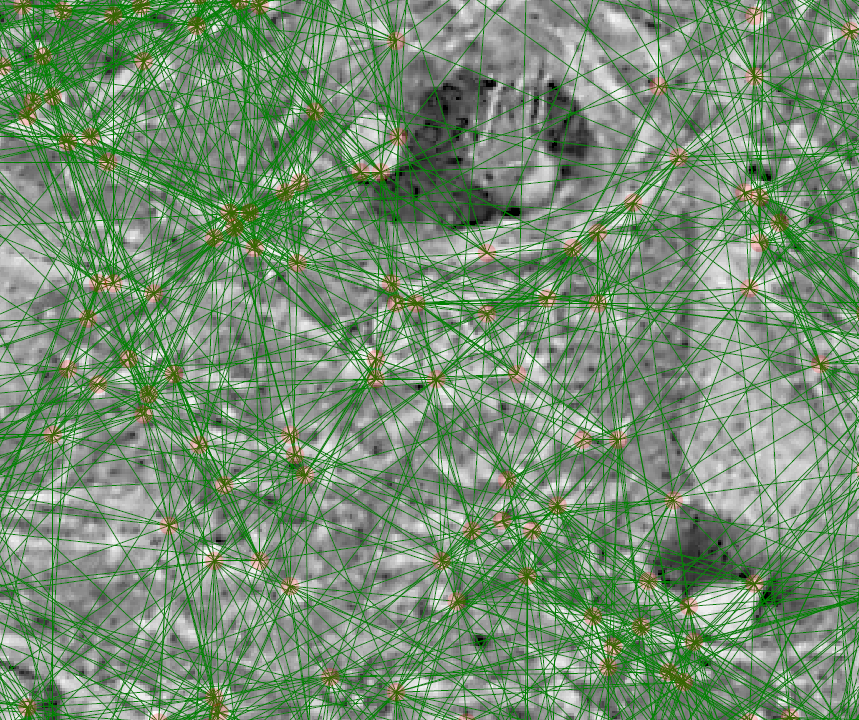

In [28]:
from IPython.display import Image

fig = Image(filename=('green.png'),width=400)
fig

x_peak y_peak peak_value
------ ------ ----------
    58      1  19.734795
   950      1  23.248022
    88      3  17.002285
   248      3  17.783003
  1180      3  18.910704
   342      5  19.344437
   376      5  21.122736
   654      5  20.428766
   938      5  21.122736
   358      7  17.522762


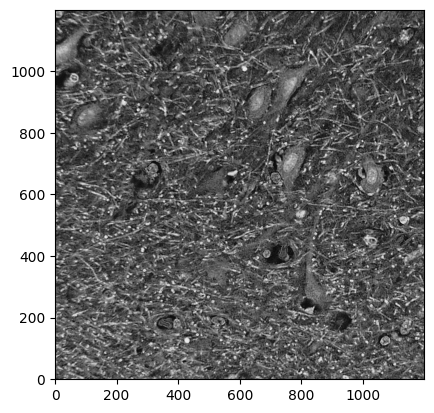

In [173]:
im=fits.open('CORTEX40.fits')[0]
plt.imshow(im.data,cmap='Greys_r',origin='lower')
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_100gaussians_image
from photutils.detection import find_peaks

mean, median, std = sigma_clipped_stats(im.data, sigma=3.0)
threshold = median + (5* std)
tbl = find_peaks(im.data, threshold, box_size=10)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(tbl[:10])  # print only the first 10 peaks
tbl.write('peaks_cor.csv' , format='ascii', overwrite=True)

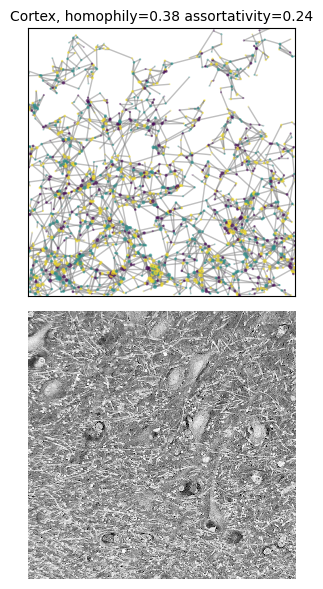

In [112]:
im=fits.open('CORTEX40.fits')[0]
data=ascii.read('peaks_cor.csv')
G=G_cortex[0]
groups = set(nx.get_node_attributes(G,'attr_dict').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['attr_dict']] for n in nodes]
plt.figure(figsize=[3.5,6],layout='tight')
pos={}
for i in range(len(data)):
    pos[i]=data['x_peak'][i],data['y_peak'][i]
    
#G = nx.from_numpy_array(A)
#G=G_cortex[0]
#im=fits.open('CEREBELLUM40.fits')[0]

plt.subplot(2,1,1)
plt.title('Cortex, homophily='+str(0.38)+' assortativity='+ str(0.24),fontsize=10)
d = dict(G.degree)
norm = simple_norm(np.zeros(np.shape(im.data)), 'sqrt', percent=99.9)
plt.imshow(im.data, cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
nx.draw_networkx_nodes(G = G, pos = pos, node_color = colors, alpha = .5, node_size=[ (v**2) * .05 for v in d.values()])#,edgecolors='k')
nx.draw_networkx_edges(G = G, pos = pos, edge_color='gray',width=1, alpha=.5, arrows = False)

plt.subplot(2,1,2)
norm = simple_norm(im.data, 'sqrt', percent=99.9)
plt.imshow(im.data, cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
plt.axis('off')
plt.ylabel('Image')

plt.savefig('r=24 cortex.pdf',dpi=1000,overwrite=True)
# save the matrix

# hdu=fits.PrimaryHDU(A)
# hdul = fits.HDUList([hdu])
# #hdul.writeto('Adj_Matrix_Peaks_r=40.fits',overwrite=True)

x_peak y_peak peak_value
------ ------ ----------
   162      1   14.40993
   552      1  13.378483
   746      1  11.740302
   778      1  13.196464
   790      1  14.349257
   864      1  12.377372
  1096      1  14.015553
   154      3  14.106565
   298      3  11.800975
   586      3  12.043668


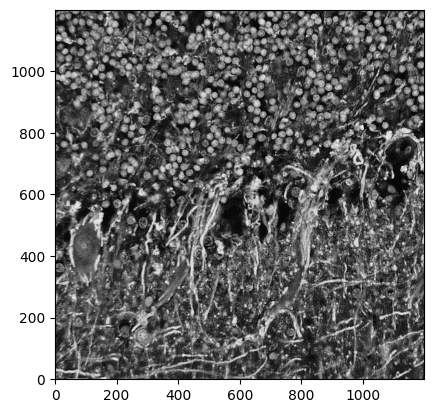

In [175]:
im=fits.open('CEREBELLUM40.fits')[0]
plt.imshow(im.data,cmap='Greys_r',origin='lower')
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_100gaussians_image
from photutils.detection import find_peaks

mean, median, std = sigma_clipped_stats(im.data, sigma=3.0)
threshold = median + (3* std)
tbl = find_peaks(im.data, threshold, box_size=10)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(tbl[:10])  # print only the first 10 peaks
tbl.write('peaks_cel.csv' , format='ascii', overwrite=True)

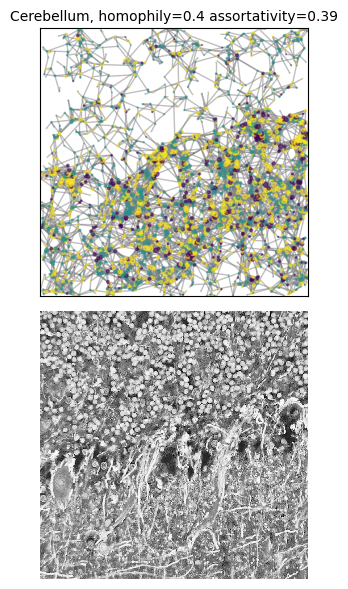

In [113]:
im=fits.open('CEREBELLUM40.fits')[0]
data=ascii.read('peaks_cel.csv')
G=G_CEREBELLUM[0]
groups = set(nx.get_node_attributes(G,'attr_dict').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['attr_dict']] for n in nodes]
plt.figure(figsize=[3.5,6],layout='tight')
pos={}
for i in range(len(data)):
    pos[i]=data['x_peak'][i],data['y_peak'][i]
    
#G = nx.from_numpy_array(A)
#G=G_CEREBELLUM[0]
#im=fits.open('CEREBELLUM40.fits')[0]

plt.subplot(2,1,1)
plt.title('Cerebellum, homophily='+str(0.40)+' assortativity='+ str(0.39),fontsize=10)
d = dict(G.degree)
norm = simple_norm(np.zeros(np.shape(im.data)), 'sqrt', percent=99.9)
plt.imshow(im.data, cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
nx.draw_networkx_nodes(G = G, pos = pos, node_color = colors, alpha = .5, node_size=[ (v**2) * .05 for v in d.values()])#,edgecolors='k')
nx.draw_networkx_edges(G = G, pos = pos, edge_color='gray',width=1, alpha=.5, arrows = False)

plt.subplot(2,1,2)
norm = simple_norm(im.data, 'sqrt', percent=99.9)
plt.imshow(im.data, cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
plt.axis('off')
plt.ylabel('Image')

plt.savefig('r=24 cel.pdf',dpi=1000,overwrite=True)
# save the matrix

# hdu=fits.PrimaryHDU(A)
# hdul = fits.HDUList([hdu])
# #hdul.writeto('Adj_Matrix_Peaks_r=40.fits',overwrite=True)

# Robustness

In [7]:
from __future__ import division
import numpy as np
import networkx as nx
import time 
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import operator
from progressbar import ProgressBar
from random import seed, random
import scipy as sci
import sklearn
import seaborn as sns
from sklearn import metrics
import os

In [9]:
def random_centrality(G):
    seed(1)
    rnd = {}
    nodes = list(G.nodes())
    for i in range(len(nodes)):
        rnd[nodes[i]]=random()
    return rnd

In [10]:
def cent(G):
    t=[]
    cen=[]
    Dict={}

    if 1==1:
        cen.append('random')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=random_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')    

    if 1==1:
        cen.append('degree')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.degree_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')
        
    if 1==1:
        cen.append('eigenvector')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.eigenvector_centrality(G,tol = 10**-2)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')

    if 1==0:
        cen.append('katz')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.katz_centrality(G, alpha=0.001)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')

    if 1==1:
        cen.append('closeness')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.closeness_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')

    if 1==0:
        cen.append('current_flow_closeness')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.current_flow_closeness_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')
        
    if 1==0:
        cen.append('information')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.information_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')

    if 1==1:
        cen.append('betweenness')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.betweenness_centrality(G,normalized=False,endpoints=True)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')
        
    if 1==0:
        cen.append('current_flow_betweenness')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.current_flow_betweenness_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')

    if 1==0:
        cen.append('communicability_betweenness')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.communicability_betweenness_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')

    if 1==0:
        cen.append('load')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.load_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')

    if 1==0:
        cen.append('subgraph')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.subgraph_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')
        #print(0,Dict[cen[-1]])
        
    if 1==0:
        cen.append('subgraph_exp')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.subgraph_centrality(G)
        #Dict[cen[-1]]=nx.subgraph_centrality_exp(G) ####### NOTE ! #####
        t_f = time.time()
        t.append(t_f-t_i)
        #print(1,Dict[cen[-1]])
        #print(cen[-1],' centrality calculated')

    if 1==0:
        cen.append('harmonic')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.harmonic_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')

    if 1==0:
        cen.append('order')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.second_order_centrality(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')

    if 1==1:
        cen.append('pagerank')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.pagerank(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated')
        
    if 1==0:
        cen.append('clustering')
        print(cen[-1],' centrality analysis started')
        t_i = time.time()
        Dict[cen[-1]]=nx.clustering(G)
        t_f = time.time()
        t.append(t_f-t_i)
        #print(cen[-1],' centrality calculated') 
         
    #m=len(cen)
    #np.save('centrality.npy', Dict)   
    #np.save('pearson_correlation.npy', pearson)   
    #np.save('spearman_correlation.npy', spearman)   
    #np.save('mutual_info_correlation.npy', mutual_info) 
    
    return cen, t, Dict    


In [128]:
def LCC_contract(G):
    t_i = time.time()
    print('######## node centrality analysis started ##########')
    cen,t,Dict=cent(G)
    print('######## node centrality analysis done ##########')
    n = len(Dict)
    print( ' number of centrality measures = ', n )
    
    robustness = {}
    print('######## network robustness analysis started ##########')
    for i in range(n):
        #print(' network being attacked based on ', cen[i] , 'centrality ')
        G_ = G.copy()
        lcc=[]
        cen_i = {}
        cen_i = Dict[cen[i]]
        for j in range(nx.number_of_nodes(G)):
            lcc_size = len(max(nx.connected_components(G_), key = len))
            if lcc_size>1:
                lcc.append(lcc_size)
                #print(cen[i],j,type(cen_i))
                c = max(cen_i.items(), key=operator.itemgetter(1))[0]
                G_.remove_node(int(c))
                del cen_i[c]
            else:
                lcc.append(0)
        #print(' network dismantled using ', cen[i] , 'centrality ')
        robustness[cen[i]] = lcc
    t_f = time.time()
    print('######## robustness analysis done ##########')
    print((t_f-t_i)/60, 'minutes')
    
    #np.save('robustness.npy', robustness) 
    
    return cen, t, Dict, robustness

In [266]:
G=G_CEREBELLUM[0]
#G=G_cortex[0]
#G=G_Galaxy[0]
cen, t, cen_dict, robustness=LCC_contract(G)

######## node centrality analysis started ##########
random  centrality analysis started
degree  centrality analysis started
eigenvector  centrality analysis started
closeness  centrality analysis started
betweenness  centrality analysis started
pagerank  centrality analysis started
######## node centrality analysis done ##########
 number of centrality measures =  6
######## network robustness analysis started ##########
######## robustness analysis done ##########
0.900426467259725 minutes


100%|██████████| 6/6 [00:00<00:00, 369.58it/s]


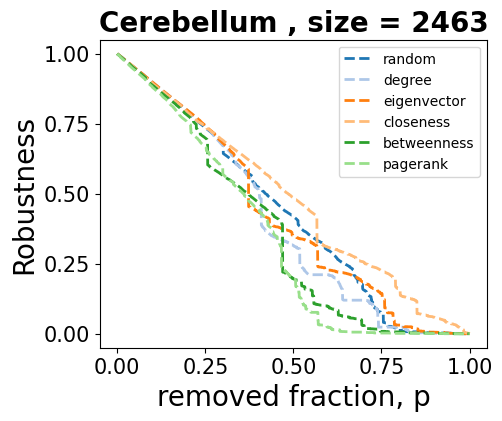

In [267]:
network = 'Cerebellum'
palette = sns.color_palette('tab20',len(cen))
colors={}
for i in range(len(cen)):
    colors[cen[i]]=palette[i]
        


N = len(G.nodes())
remain_node=np.linspace(N,1,N)
alph=1;w=1;w1=2;f=20;f1=15
removed_frac=np.linspace(0,1,N)
plt.figure(figsize=[5,4])

#for i in range(len(cen)-3):
#    plt.plot(removed_frac,np.array(robustness[cen[i+3]])/N,linewidth=w,alpha=alph, color=colors[cen[i+3]],label=cen[i+3])       
for i in tqdm.tqdm(range(len(cen))):
    plt.plot(removed_frac,np.array(robustness[cen[i]])/N,'--',linewidth=w1,alpha=1,color=colors[cen[i]],label=cen[i])
#plt.plot(removed_frac,np.array(robustness[cen[1]])/N,'--',linewidth=w1,alpha=1,color=colors[cen[1]],label=cen[1])
#plt.plot(removed_frac,np.array(robustness[cen[2]])/N,'--',linewidth=w1,alpha=1,color=colors[cen[2]],label=cen[2])


plt.title(network+' , size = ' + str(N),fontsize=f, fontweight='bold')
plt.xticks(np.linspace(0,1,5),fontsize=f1)
plt.yticks(np.linspace(0,1,5),fontsize=f1)
plt.ylabel('Robustness',fontsize=f)
plt.xlabel('removed fraction, p',fontsize=f)
#plt.legend()

#plt.xscale('log')
plt.xlim(-0.05,1.05)
plt.legend()
#plt.savefig('robustness.png',edgecolor='w', bbox_inches="tight",dpi=300,format='png')
#plt.savefig('robustness.pdf',edgecolor='w', bbox_inches="tight",dpi=300,format='pdf')

In [268]:
#G=G_CEREBELLUM[0]
G=G_cortex[0]
#G=G_Galaxy[0]
cen, t, cen_dict, robustness=LCC_contract(G)

######## node centrality analysis started ##########
random  centrality analysis started
degree  centrality analysis started
eigenvector  centrality analysis started
closeness  centrality analysis started
betweenness  centrality analysis started
pagerank  centrality analysis started
######## node centrality analysis done ##########
 number of centrality measures =  6
######## network robustness analysis started ##########
######## robustness analysis done ##########
0.3107324043909709 minutes


100%|██████████| 6/6 [00:00<00:00, 312.44it/s]


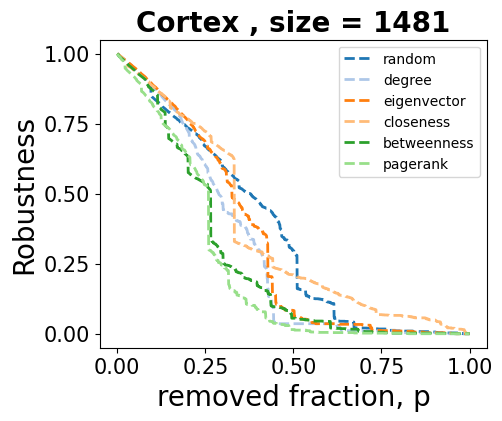

In [269]:
network = 'Cortex'
palette = sns.color_palette('tab20',len(cen))
colors={}
for i in range(len(cen)):
    colors[cen[i]]=palette[i]
        


N = len(G.nodes())
remain_node=np.linspace(N,1,N)
alph=1;w=1;w1=2;f=20;f1=15
removed_frac=np.linspace(0,1,N)
plt.figure(figsize=[5,4])

#for i in range(len(cen)-3):
#    plt.plot(removed_frac,np.array(robustness[cen[i+3]])/N,linewidth=w,alpha=alph, color=colors[cen[i+3]],label=cen[i+3])       
for i in tqdm.tqdm(range(len(cen))):
    plt.plot(removed_frac,np.array(robustness[cen[i]])/N,'--',linewidth=w1,alpha=1,color=colors[cen[i]],label=cen[i])
#plt.plot(removed_frac,np.array(robustness[cen[1]])/N,'--',linewidth=w1,alpha=1,color=colors[cen[1]],label=cen[1])
#plt.plot(removed_frac,np.array(robustness[cen[2]])/N,'--',linewidth=w1,alpha=1,color=colors[cen[2]],label=cen[2])


plt.title(network+' , size = ' + str(N),fontsize=f, fontweight='bold')
plt.xticks(np.linspace(0,1,5),fontsize=f1)
plt.yticks(np.linspace(0,1,5),fontsize=f1)
plt.ylabel('Robustness',fontsize=f)
plt.xlabel('removed fraction, p',fontsize=f)
#plt.legend()

#plt.xscale('log')
plt.xlim(-0.05,1.05)
plt.legend()
#plt.savefig('robustness.png',edgecolor='w', bbox_inches="tight",dpi=300,format='png')
#plt.savefig('robustness.pdf',edgecolor='w', bbox_inches="tight",dpi=300,format='pdf')

######## node centrality analysis started ##########
random  centrality analysis started
degree  centrality analysis started
eigenvector  centrality analysis started
closeness  centrality analysis started
betweenness  centrality analysis started
pagerank  centrality analysis started
######## node centrality analysis done ##########
 number of centrality measures =  6
######## network robustness analysis started ##########
######## robustness analysis done ##########
2.185333490371704 minutes


100%|██████████| 6/6 [00:00<00:00, 373.94it/s]


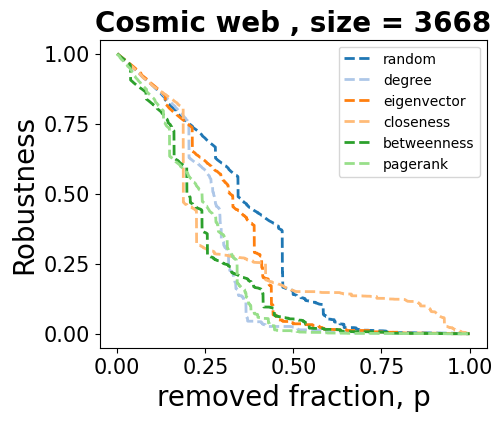

In [270]:
#G=G_CEREBELLUM[0]
#G=G_cortex[0]
G=G_Galaxy[0]
cen, t, cen_dict, robustness=LCC_contract(G)
network = 'Cosmic web'
palette = sns.color_palette('tab20',len(cen))
colors={}
for i in range(len(cen)):
    colors[cen[i]]=palette[i]
        


N = len(G.nodes())
remain_node=np.linspace(N,1,N)
alph=1;w=1;w1=2;f=20;f1=15
removed_frac=np.linspace(0,1,N)
plt.figure(figsize=[5,4])

#for i in range(len(cen)-3):
#    plt.plot(removed_frac,np.array(robustness[cen[i+3]])/N,linewidth=w,alpha=alph, color=colors[cen[i+3]],label=cen[i+3])       
for i in tqdm.tqdm(range(len(cen))):
    plt.plot(removed_frac,np.array(robustness[cen[i]])/N,'--',linewidth=w1,alpha=1,color=colors[cen[i]],label=cen[i])
#plt.plot(removed_frac,np.array(robustness[cen[1]])/N,'--',linewidth=w1,alpha=1,color=colors[cen[1]],label=cen[1])
#plt.plot(removed_frac,np.array(robustness[cen[2]])/N,'--',linewidth=w1,alpha=1,color=colors[cen[2]],label=cen[2])


plt.title(network+' , size = ' + str(N),fontsize=f, fontweight='bold')
plt.xticks(np.linspace(0,1,5),fontsize=f1)
plt.yticks(np.linspace(0,1,5),fontsize=f1)
plt.ylabel('Robustness',fontsize=f)
plt.xlabel('removed fraction, p',fontsize=f)
#plt.legend()

#plt.xscale('log')
plt.xlim(-0.05,1.05)
plt.legend()
#plt.savefig('robustness.png',edgecolor='w', bbox_inches="tight",dpi=300,format='png')
#plt.savefig('robustness.pdf',edgecolor='w', bbox_inches="tight",dpi=300,format='pdf')

In [135]:
e = np.array(list(G_CEREBELLUM[0].edges()))
np.save('G_CEREBELLUM',e)

In [136]:
e = np.array(list(G_cortex[0].edges()))
np.save('G_cortex',e)

In [137]:
e = np.array(list(G_Galaxy[0].edges()))
np.save('G_Galaxy',e)

# Degree Distrebution

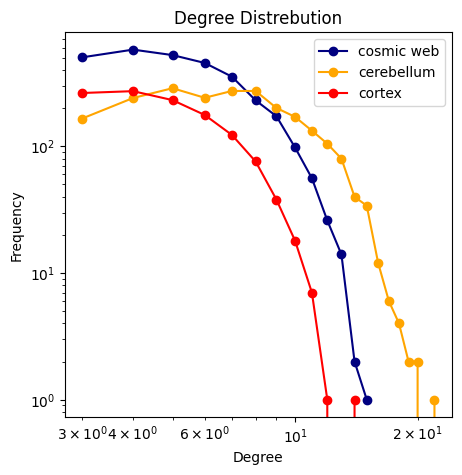

In [251]:
G=G_Galaxy[0]
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(5, 5)) 
plt.loglog(degrees[m:], degree_freq[m:],'go-',label='cosmic web',color='navy') 
#plt.plot(degrees[m:], degree_freq[m:],'go-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')

G=G_CEREBELLUM[0]
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq)) 
plt.loglog(degrees[m:], degree_freq[m:],'go-',label='cerebellum',color='orange') 
#plt.plot(degrees[m:], degree_freq[m:],'go-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')


G=G_cortex[0]
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.loglog(degrees[m:], degree_freq[m:],'go-',label='cortex',color='red') 
#plt.plot(degrees[m:], degree_freq[m:],'go-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title("Degree Distrebution")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


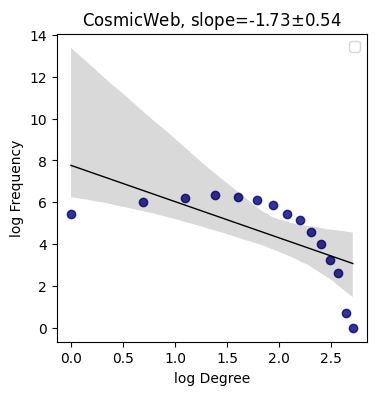

In [261]:
G=G_Galaxy[0]
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(4, 4)) 
df = pd.DataFrame()
df['x']=np.log(np.linspace(0,len(degree_freq)-1,len(degree_freq))[1:])
df['y']=np.log(np.array(degree_freq[1:]))
p = sns.regplot(x='x', y='y',data=df
                ,scatter=True,color='navy',x_ci=False, line_kws={'linewidth':1,"color": "black"})
slope, intercept, r, p, sterr = sci.stats.linregress(x=df['x'].values,
                                                           y=df['y'].values)
plt.title('CosmicWeb, slope='+str(round(slope,2))+ r'$\pm$'+str(round(sterr,2)))

plt.xlabel('log Degree')
plt.ylabel('log Frequency')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


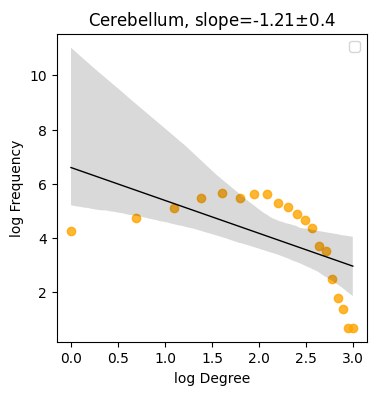

In [262]:
G=G_CEREBELLUM[0]
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(4, 4)) 
df = pd.DataFrame()
df['x']=np.log(np.linspace(0,len(degree_freq)-1,len(degree_freq))[1:-2])
df['y']=np.log(np.array(degree_freq[1:-2]))
p = sns.regplot(x='x', y='y',data=df
                ,scatter=True,color='orange',x_ci=False, line_kws={'linewidth':1,"color": "black"})
slope, intercept, r, p, sterr = sci.stats.linregress(x=df['x'].values,
                                                           y=df['y'].values)
plt.title('Cerebellum, slope='+str(round(slope,2))+ r'$\pm$'+str(round(sterr,2)))

plt.xlabel('log Degree')
plt.ylabel('log Frequency')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


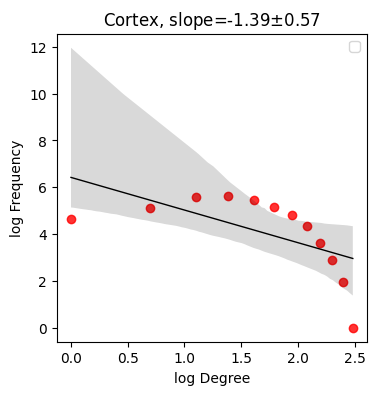

In [263]:
G=G_cortex[0]
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(4, 4)) 
df = pd.DataFrame()
df['x']=np.log(np.linspace(0,len(degree_freq)-1,len(degree_freq))[1:-2])
df['y']=np.log(np.array(degree_freq[1:-2]))
p = sns.regplot(x='x', y='y',data=df
                ,scatter=True,color='red',x_ci=False, line_kws={'linewidth':1,"color": "black"})
slope, intercept, r, p, sterr = sci.stats.linregress(x=df['x'].values,
                                                           y=df['y'].values)
plt.title('Cortex, slope='+str(round(slope,2))+ r'$\pm$'+str(round(sterr,2)))

plt.xlabel('log Degree')
plt.ylabel('log Frequency')
plt.legend()

In [180]:
x=np.log(np.linspace(0,14,15)+0.00001)

In [209]:
x[1:]

array([9.99995000e-06, 6.93152181e-01, 1.09861562e+00, 1.38629686e+00,
       1.60943991e+00, 1.79176114e+00, 1.94591158e+00, 2.07944279e+00,
       2.19722569e+00, 2.30258609e+00, 2.39789618e+00, 2.48490748e+00,
       2.56495013e+00, 2.63905804e+00])

[0, 104, 167, 264, 273, 232, 177, 123, 76, 38, 18, 7, 1, 0, 1]

In [273]:
pr = nx.pagerank(G, alpha=0.9)

In [349]:
G=G_Galaxy[0]
d=dict(G.degree)
dc=nx.degree_centrality(G)
pr = nx.pagerank(G, alpha=0.9)

Text(0, 0.5, 'PageRank')

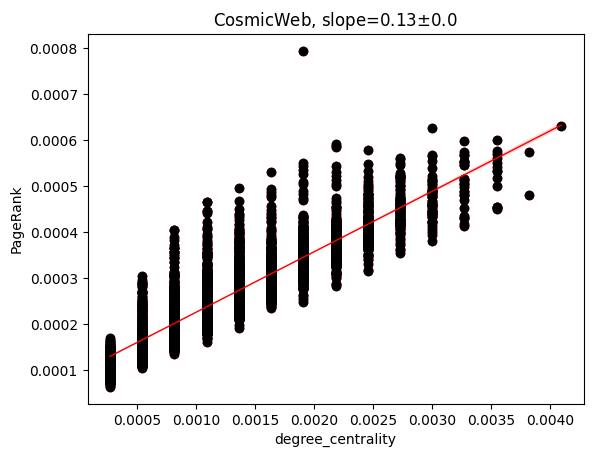

In [396]:
plt.plot(dc.values(),pr.values(),'o',color='k')
df=pd.DataFrame()
df['x']=dc.values()
df['y']=pr.values()
p = sns.regplot(x='x', y='y',data=df
                ,scatter=True,color='red',x_ci=False, line_kws={'linewidth':1,"color": "red"})
slope, intercept, r, p, sterr = sci.stats.linregress(x=df['x'].values,
                                                           y=df['y'].values)
plt.title('CosmicWeb, slope='+str(round(slope,2))+ r'$\pm$'+str(round(sterr,2)))
plt.xlabel('degree_centrality')
plt.ylabel('PageRank')

Text(0.5, 1.0, 'CosmicWeb degree distrebution')

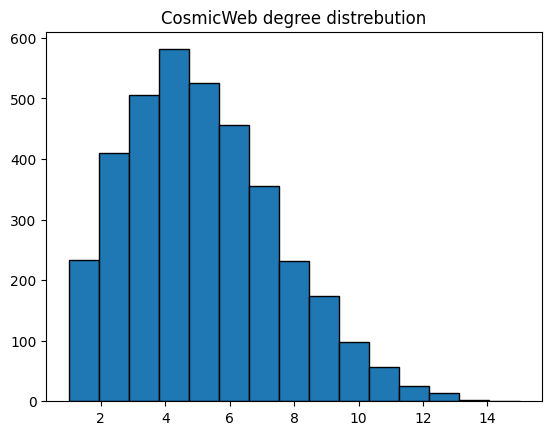

In [389]:
plt.hist(d.values(),log=False, bins=15,edgecolor='black')
plt.title('CosmicWeb degree distrebution')

Text(0, 0.5, 'PageRank')

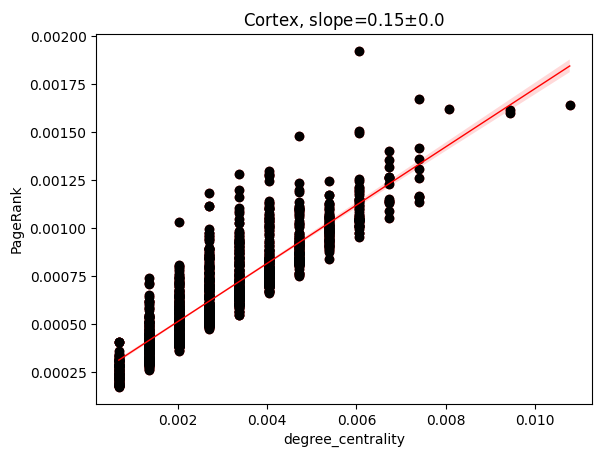

In [32]:
G=G_cortex[0]
d=dict(G.degree)
dc=nx.degree_centrality(G)
pr = nx.pagerank(G, alpha=0.9)
plt.plot(dc.values(),pr.values(),'o',color='k')
df=pd.DataFrame()
df['x']=dc.values()
df['y']=pr.values()
p = sns.regplot(x='x', y='y',data=df
                ,scatter=True,color='red',x_ci=False, line_kws={'linewidth':1,"color": "red"})
slope, intercept, r, p, sterr = sci.stats.linregress(x=df['x'].values,
                                                           y=df['y'].values)
plt.title('Cortex, slope='+str(round(slope,2))+ r'$\pm$'+str(round(sterr,2)))
plt.xlabel('degree_centrality')
plt.ylabel('PageRank')


Text(0.5, 1.0, 'Cortex degree distrebution')

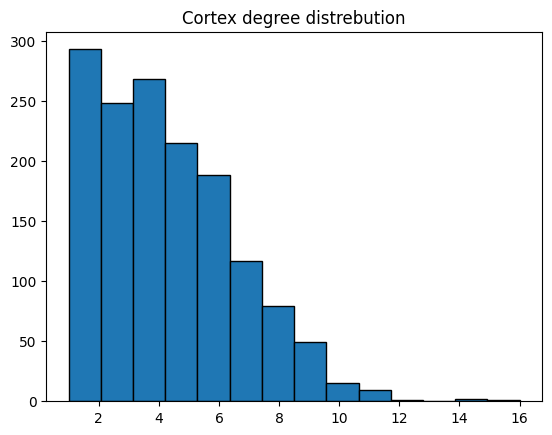

In [33]:
plt.hist(d.values(),log=False, bins=14,edgecolor='black')
plt.title('Cortex degree distrebution')

Text(0, 0.5, 'PageRank')

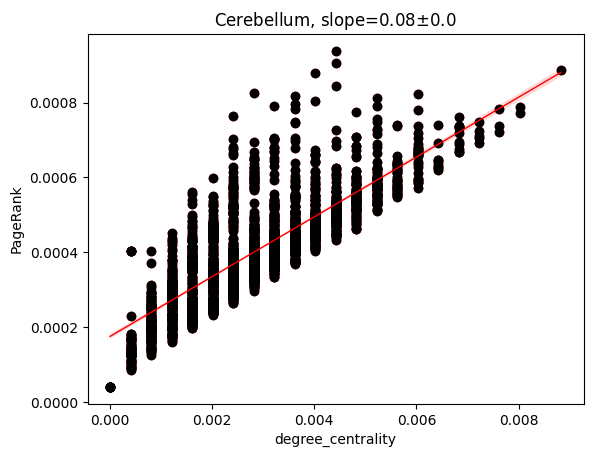

In [34]:
G=G_CEREBELLUM[0]
d=dict(G.degree)
dc=nx.degree_centrality(G)
pr = nx.pagerank(G, alpha=0.9)
d=dict(G.degree)
dc=nx.degree_centrality(G)
pr = nx.pagerank(G, alpha=0.9)
plt.plot(dc.values(),pr.values(),'o',color='k')
df=pd.DataFrame()
df['x']=dc.values()
df['y']=pr.values()
p = sns.regplot(x='x', y='y',data=df
                ,scatter=True,color='red',x_ci=False, line_kws={'linewidth':1,"color": "red"})
slope, intercept, r, p, sterr = sci.stats.linregress(x=df['x'].values,
                                                           y=df['y'].values)
plt.title('Cerebellum, slope='+str(round(slope,2))+ r'$\pm$'+str(round(sterr,2)))
plt.xlabel('degree_centrality')
plt.ylabel('PageRank')

Text(0.5, 1.0, 'Cerebellum degree distrebution')

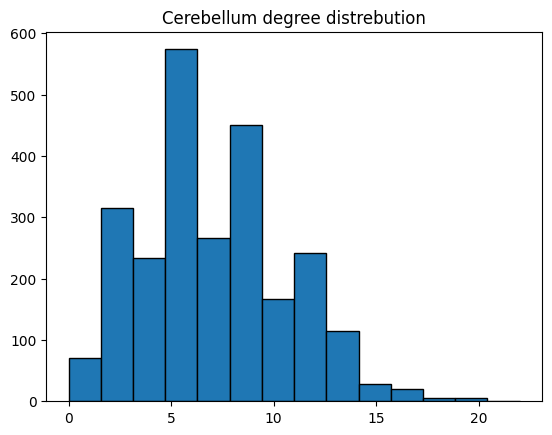

In [35]:
plt.hist(d.values(),log=False, bins=14,edgecolor='black')
plt.title('Cerebellum degree distrebution')

In [27]:
df


x         y
0     0.004043  0.000731
1     0.004717  0.000920
2     0.001348  0.000325
3     0.000674  0.000229
4     0.001348  0.000375
...        ...       ...
1480  0.002022  0.000734
1481  0.000674  0.000335
1482  0.002695  0.001181
1483  0.000674  0.000335
1484  0.000674  0.000263

[1485 rows x 2 columns]

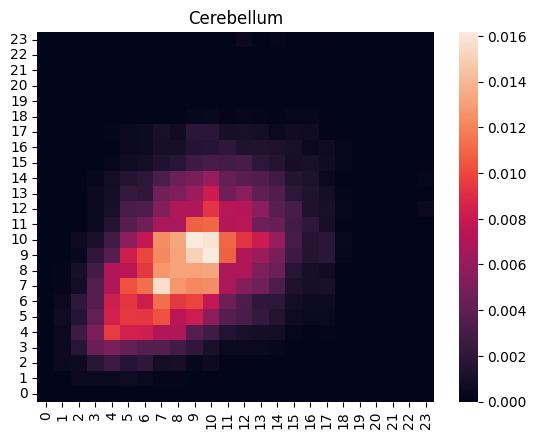

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

G=G_CEREBELLUM[0]
mix_mat = nx.degree_mixing_matrix(G)
ax = sns.heatmap(mix_mat)
plt.title('Cerebellum')
plt.gca().invert_yaxis()
plt.show()

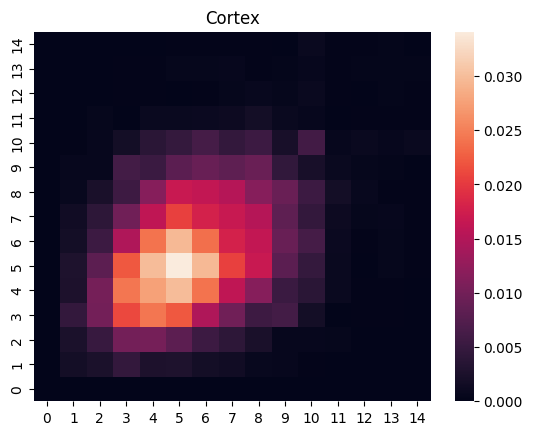

In [38]:
G=G_cortex[0]
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

mix_mat = nx.degree_mixing_matrix(G)
ax = sns.heatmap(mix_mat)
plt.title('Cortex')
plt.gca().invert_yaxis()
plt.show()

In [19]:
mix

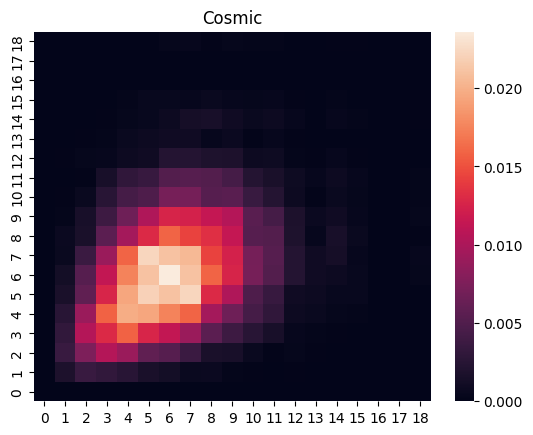

In [40]:
G=G_Galaxy[0]
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

mix_mat = nx.degree_mixing_matrix(G)
ax = sns.heatmap(mix_mat)
plt.title('Cosmic')
plt.gca().invert_yaxis()
plt.show()

In [70]:
nx.attribute_mixing_matrix(G, "attr_dict")

array([[4.51983410e-02, 1.31128363e-01, 6.06189514e-03],
       [1.31128363e-01, 6.58938637e-01, 1.04222057e-02],
       [6.06189514e-03, 1.04222057e-02, 6.38094225e-04]])

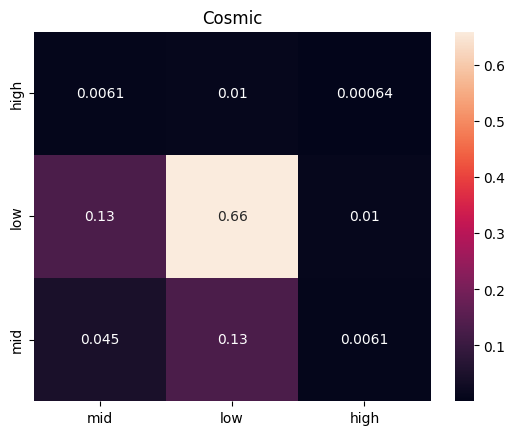

In [71]:
G=G_Galaxy[0]
labels=['mid','low','high']

mix_mat=nx.attribute_mixing_matrix(G, "attr_dict")
df_cm = pd.DataFrame(mix_mat, index = labels,
                  columns = labels)
ax = sns.heatmap(df_cm , annot=True)
plt.title('Cosmic')
plt.gca().invert_yaxis()
plt.show()

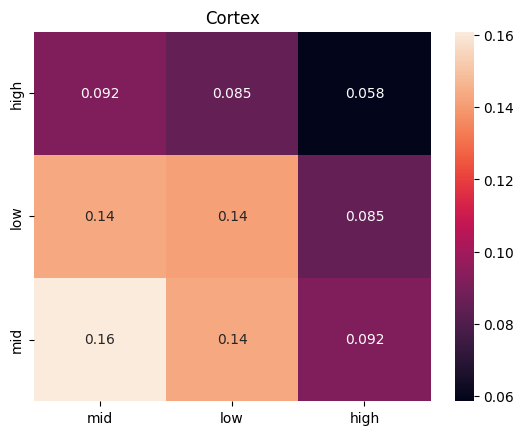

In [72]:
G=G_cortex[0]
mix_mat=nx.attribute_mixing_matrix(G, "attr_dict")
df_cm = pd.DataFrame(mix_mat, index = labels,
                  columns = labels)
ax = sns.heatmap(df_cm , annot=True)
plt.title('Cortex')
plt.gca().invert_yaxis()
plt.show()

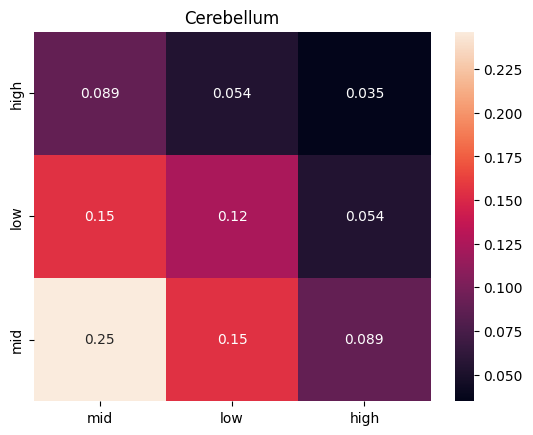

In [73]:
G=G_CEREBELLUM[0]
mix_mat=nx.attribute_mixing_matrix(G, "attr_dict")
df_cm = pd.DataFrame(mix_mat, index = labels,
                  columns = labels)
ax = sns.heatmap(df_cm , annot=True)
plt.title('Cerebellum')
plt.gca().invert_yaxis()
plt.show()